In [32]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from datetime import datetime
from tqdm import tqdm
from collections import deque
import time
import json
import gc

from scipy.signal import savgol_filter
from scipy.stats import f_oneway, entropy, zscore
from scipy.interpolate import interp1d

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.datasets import load_iris

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, Dense, Layer, Dropout, LayerNormalization, 
    MultiHeadAttention, Conv1D, BatchNormalization, MaxPooling1D, concatenate, GroupNormalization, GlobalAveragePooling1D, Add
)
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from tensorflow.keras.losses import Huber, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecay
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import skew, kurtosis




In [2]:
df = pd.read_csv('tes_balancedv7.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175115 entries, 0 to 175114
Data columns (total 62 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   File Name              175115 non-null  object 
 1   Frame                  175115 non-null  int64  
 2   Neck Angle             175115 non-null  float64
 3   Left Upper Arm Angle   175115 non-null  float64
 4   Right Upper Arm Angle  175115 non-null  float64
 5   Left Lower Arm Angle   175115 non-null  float64
 6   Right Lower Arm Angle  175115 non-null  float64
 7   Waist Angle            175115 non-null  float64
 8   Left Leg Angle         175115 non-null  float64
 9   Right Leg Angle        175115 non-null  float64
 10  Upper Arm REBA         175115 non-null  int64  
 11  Lower Arm REBA         175115 non-null  int64  
 12  Neck REBA              175115 non-null  int64  
 13  Trunk REBA             175115 non-null  int64  
 14  Leg REBA               175115 non-nu

In [3]:
df.isnull().sum()

File Name                    0
Frame                        0
Neck Angle                   0
Left Upper Arm Angle         0
Right Upper Arm Angle        0
                         ...  
right_knee Y             27082
left_ankle X             97571
left_ankle Y             97571
right_ankle X            92046
right_ankle Y            92046
Length: 62, dtype: int64

In [4]:
df = df.drop(columns=[
    'left_wrist X', 'left_wrist Y',   
    'right_wrist X', 'right_wrist Y',
    'left_ankle X', 'left_ankle Y',
    'right_ankle X', 'right_ankle Y'
])

In [5]:
class KeypointSmoother:
    """Enhanced smoother that respects your existing pipeline"""
    def __init__(self, window_size=5):
        self.window_size = window_size
        # Mirror your AngleSmoother's logic
        self.history = {
            'x': deque(maxlen=window_size),
            'y': deque(maxlen=window_size)
        }
    
    def smooth(self, coord_series):
        """Process a coordinate series with same logic as your angle smoother"""
        # Linear interpolation first
        filled = coord_series.interpolate(method='linear', limit_direction='both')
        
        # Apply similar smoothing as AngleSmoother
        smoothed = []
        for val in filled:
            self.history['x' if 'X' in coord_series.name else 'y'].append(val)
            smoothed.append(np.mean(self.history['x' if 'X' in coord_series.name else 'y']))
        
        return smoothed

def process_keypoints(df):
    """Applies consistent smoothing across all keypoints"""
    # Your existing REBA classes will use these smoothed values
    keypoint_columns = [col for col in df.columns if (' X' in col or ' Y' in col) 
                       and col not in ['nose X', 'nose Y']]
    
    for file_name, group in df.groupby('File Name'):
        smoother = KeypointSmoother(window_size=3)  # Match your angle smoother window
        
        for col in keypoint_columns:
            if df[col].isnull().any():  # Only process columns with missing values
                # Apply same smoothing logic as your angle calculations
                df.loc[group.index, col] = smoother.smooth(group[col])
    
    return df

# Apply to your dataframe
df = process_keypoints(df)

In [6]:
df.isnull().sum() 

File Name                   0
Frame                       0
Neck Angle                  0
Left Upper Arm Angle        0
Right Upper Arm Angle       0
Left Lower Arm Angle        0
Right Lower Arm Angle       0
Waist Angle                 0
Left Leg Angle              0
Right Leg Angle             0
Upper Arm REBA              0
Lower Arm REBA              0
Neck REBA                   0
Trunk REBA                  0
Leg REBA                    0
REBA Table A Score          0
REBA Table B Score          0
REBA Table C Score          0
REBA Grand Total            0
REBA Risk Level             0
Neck Imputed                0
Left Arm Imputed            0
Right Arm Imputed           0
Left Elbow Imputed          0
Right Elbow Imputed         0
Waist Imputed               0
Left Leg Imputed            0
Right Leg Imputed           0
nose X                   1200
nose Y                   1200
left_eye X                  0
left_eye Y                  0
right_eye X                 0
right_eye 

In [7]:
df.duplicated().sum()

0

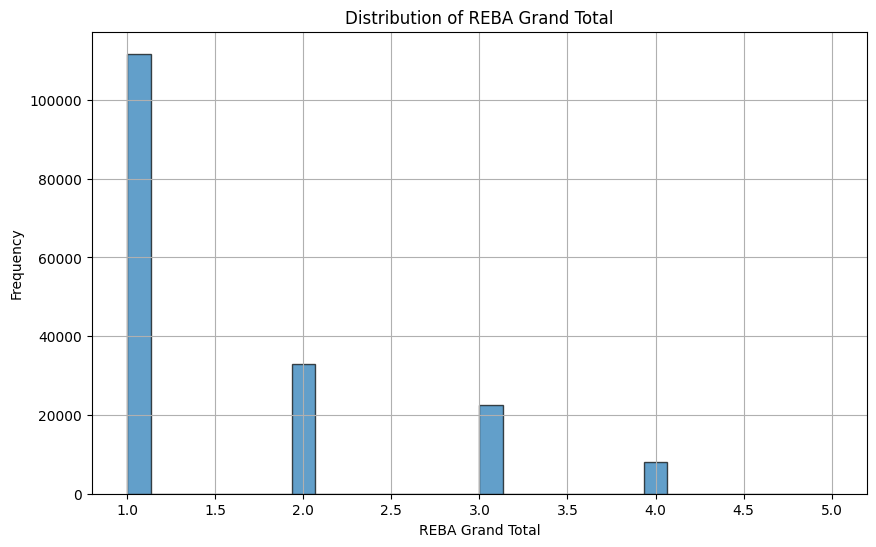

REBA Grand Total
1    63.805499
2    18.799075
3    12.816149
4     4.576992
5     0.002284
Name: proportion, dtype: float64


In [8]:
# Check the distribution of REBA Grand Total
plt.figure(figsize=(10, 6))
plt.hist(df['REBA Grand Total'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of REBA Grand Total')
plt.xlabel('REBA Grand Total')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate percentage distribution of REBA Grand Total
reba_percentage = df['REBA Grand Total'].value_counts(normalize=True) * 100
reba_percentage = reba_percentage.sort_index()  # Sorting for better readability
print(reba_percentage.head(20))

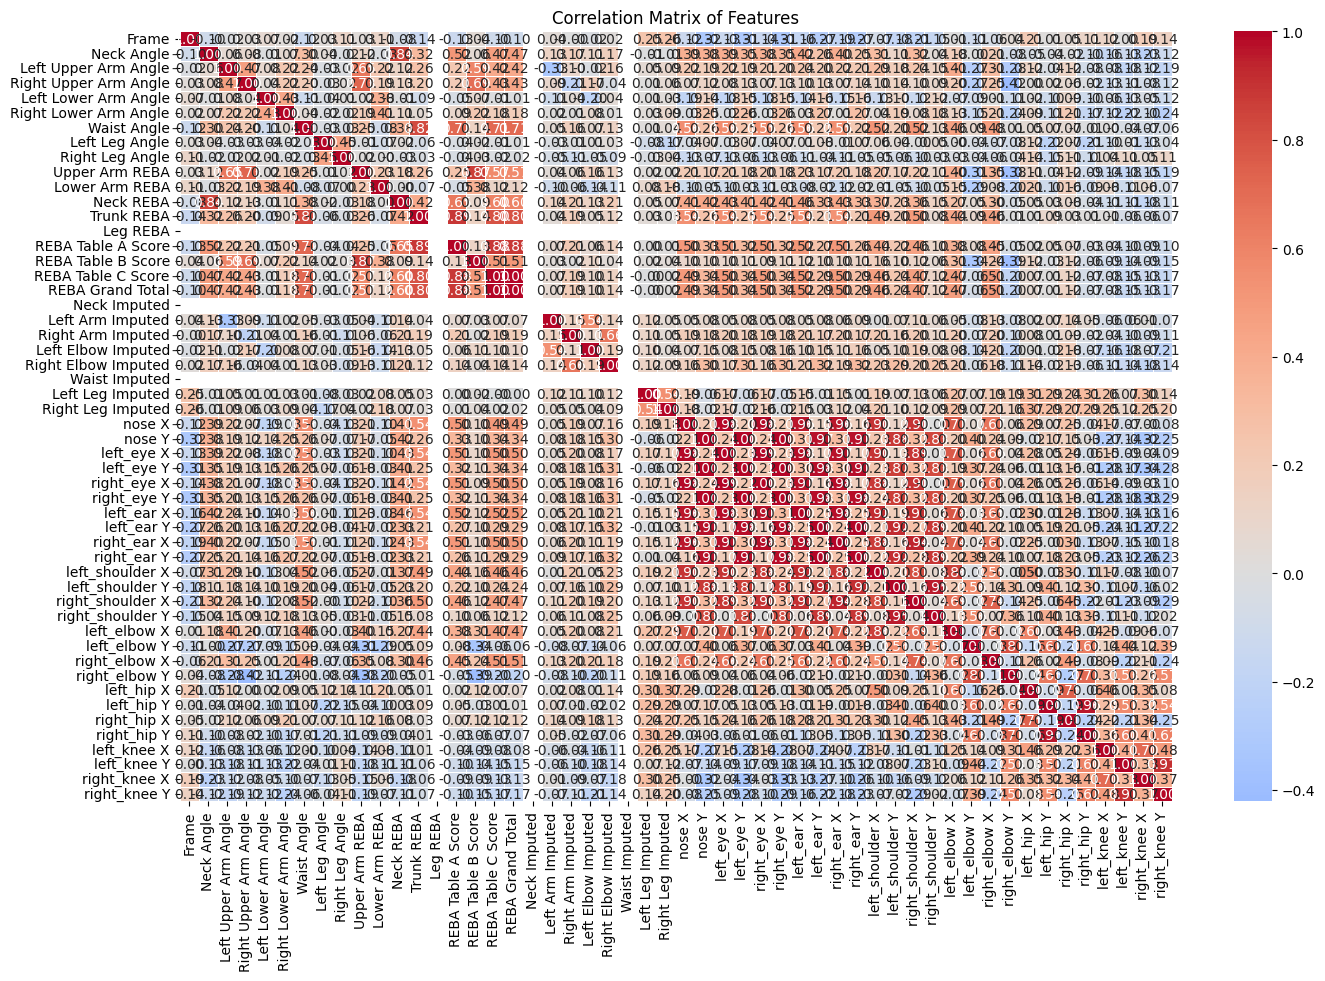

In [9]:
df_numerical = df.drop(['REBA Risk Level', 'File Name'], axis=1)

# Assuming df is your DataFrame with the necessary columns
corr_matrix = df_numerical.corr()

# Plotting the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175115 entries, 0 to 175114
Data columns (total 54 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   File Name              175115 non-null  object 
 1   Frame                  175115 non-null  int64  
 2   Neck Angle             175115 non-null  float64
 3   Left Upper Arm Angle   175115 non-null  float64
 4   Right Upper Arm Angle  175115 non-null  float64
 5   Left Lower Arm Angle   175115 non-null  float64
 6   Right Lower Arm Angle  175115 non-null  float64
 7   Waist Angle            175115 non-null  float64
 8   Left Leg Angle         175115 non-null  float64
 9   Right Leg Angle        175115 non-null  float64
 10  Upper Arm REBA         175115 non-null  int64  
 11  Lower Arm REBA         175115 non-null  int64  
 12  Neck REBA              175115 non-null  int64  
 13  Trunk REBA             175115 non-null  int64  
 14  Leg REBA               175115 non-nu

In [11]:
"""
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named df and has 'Time' and 'REBA Grand Total' columns
def plot_reba_evolution(df):
    # Ensure data is sorted by filename and frame
    df = df.sort_values(by=['File Name', 'Frame'])
    
    # Get unique filenames (i.e., videos)
    filenames = df['File Name'].unique()
    
    # Number of rows and columns for the plot grid
    num_videos = len(filenames)
    rows = (num_videos // 3) + (num_videos % 3 > 0)  # Automatically calculate number of rows
    
    # Create a figure with subplots
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
    
    for idx, filename in enumerate(filenames):
        # Filter the data for the current filename (video)
        file_data = df[df['File Name'] == filename]
        =
        # Plot the REBA Grand Total vs Time (frame converted to time)
        axes[idx].plot(file_data['Frame'], file_data['REBA Grand Total'])
        axes[idx].set_title(f'ReBA Grand Total Evolution for {filename}')
        axes[idx].set_ylabel('REBA Grand Total')
        axes[idx].tick_params(axis='x', rotation=45)
    
    # Adjust the layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example usage on your DataFrame
plot_reba_evolution(df)
"""

"\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Assuming your dataframe is named df and has 'Time' and 'REBA Grand Total' columns\ndef plot_reba_evolution(df):\n    # Ensure data is sorted by filename and frame\n    df = df.sort_values(by=['File Name', 'Frame'])\n    \n    # Get unique filenames (i.e., videos)\n    filenames = df['File Name'].unique()\n    \n    # Number of rows and columns for the plot grid\n    num_videos = len(filenames)\n    rows = (num_videos // 3) + (num_videos % 3 > 0)  # Automatically calculate number of rows\n    \n    # Create a figure with subplots\n    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))\n    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration\n    \n    for idx, filename in enumerate(filenames):\n        # Filter the data for the current filename (video)\n        file_data = df[df['File Name'] == filename]\n        =\n        # Plot the REBA Grand Total vs Time (frame converted to time)\n        axe

In [12]:
df.head()

,File Name,Frame,Neck Angle,Left Upper Arm Angle,Right Upper Arm Angle,Left Lower Arm Angle,Right Lower Arm Angle,Waist Angle,Left Leg Angle,Right Leg Angle,...,right_elbow X,right_elbow Y,left_hip X,left_hip Y,right_hip X,right_hip Y,left_knee X,left_knee Y,right_knee X,right_knee Y
0,20250317_152346-004.mp4,0,16.962613,16.483745,26.724226,110.020145,90.000000,-39.262967,112.233462,97.697287,...,0.558961,0.487801,0.449136,0.686765,0.406836,0.722287,0.593052,0.514938,0.619236,0.643881
1,20250317_152346-004.mp4,3,9.971609,16.986673,26.115371,109.652922,114.305402,-33.545726,98.257344,96.047893,...,0.516542,0.516452,0.455014,0.688095,0.404812,0.724661,0.600529,0.540643,0.610682,0.607060
2,20250317_152346-004.mp4,6,9.291175,12.794193,25.063129,105.849549,112.744511,-34.617712,58.281516,59.163280,...,0.474176,0.545217,0.456792,0.686516,0.408806,0.723207,0.608613,0.565950,0.602335,0.569211
3,20250317_152346-004.mp4,9,8.858427,13.566536,25.974544,108.410731,90.000000,-32.997287,58.090141,58.887286,...,0.473450,0.544879,0.455687,0.686203,0.408348,0.722955,0.609077,0.566393,0.602131,0.568636
4,20250317_152346-004.mp4,12,8.866074,15.931566,24.901447,111.123271,90.000000,-31.695124,57.967296,58.539484,...,0.472772,0.545266,0.459937,0.685638,0.409670,0.722700,0.609691,0.566226,0.602388,0.567579


In [13]:
"""
df['imputation_penalty'] = df[[
    'Left Arm Imputed', 'Right Arm Imputed',
    'Left Leg Imputed', 'Right Leg Imputed'
]].sum(axis=1) * 0.2

df['REBA Grand Total'] = df['REBA Grand Total'] + df['imputation_penalty']
"""

"\ndf['imputation_penalty'] = df[[\n    'Left Arm Imputed', 'Right Arm Imputed',\n    'Left Leg Imputed', 'Right Leg Imputed'\n]].sum(axis=1) * 0.2\n\ndf['REBA Grand Total'] = df['REBA Grand Total'] + df['imputation_penalty']\n"

In [14]:
class AdvancedPoseFeatures:
    def __init__(self, sequence_length=60, fps=30):
        self.sequence_length = sequence_length
        self.fps = fps
        self.core_angles = [
            'Neck Angle', 'Left Upper Arm Angle', 'Right Upper Arm Angle',
            'Left Lower Arm Angle', 'Right Lower Arm Angle', 'Waist Angle',
            'Left Leg Angle', 'Right Leg Angle'
        ]
    
    def engineer_biomechanical_features(self, df):
        """Engineer advanced biomechanical features"""
        print("🔬 Engineering advanced biomechanical features...")
        
        df = self._add_joint_coordination_features(df)
        df = self._add_stability_features(df)
        df = self._add_movement_efficiency_features(df)
        df = self._add_biomechanical_constraints(df)
        df = self._add_temporal_dynamics(df)
        df = self._add_additional_biomechanical_features(df)
        
        return df
    
    def _add_joint_coordination_features(self, df):
        """Joint coordination features"""
        for name, group in df.groupby('File Name'):
            group = group.sort_values('Frame').reset_index(drop=True)
            
            # Bilateral symmetry
            left_arm_complex = group['Left Upper Arm Angle'] + group['Left Lower Arm Angle']
            right_arm_complex = group['Right Upper Arm Angle'] + group['Right Lower Arm Angle']
            df.loc[group.index, 'arm_coordination_symmetry'] = 1 - (np.abs(left_arm_complex - right_arm_complex) / 180)
            
            leg_symmetry = 1 - (np.abs(group['Left Leg Angle'] - group['Right Leg Angle']) / 180)
            df.loc[group.index, 'leg_coordination_symmetry'] = leg_symmetry
            
            # Axial coordination
            shoulder_hip_ratio = np.abs(group['Neck Angle']) / (np.abs(group['Waist Angle']) + 1e-6)
            df.loc[group.index, 'axial_coordination'] = np.clip(1 / (1 + shoulder_hip_ratio/2), 0, 1)
            
            # Cross-body coordination
            right_arm_total = group['Right Upper Arm Angle'] + group['Right Lower Arm Angle']
            left_leg_angle = group['Left Leg Angle']
            cross_coord = np.corrcoef(right_arm_total, left_leg_angle)[0,1]
            df.loc[group.index, 'cross_body_coordination'] = np.abs(cross_coord) if not np.isnan(cross_coord) else 0
            
            # Neck-waist coupling
            neck_waist_coupling = np.corrcoef(group['Neck Angle'], group['Waist Angle'])[0,1]
            df.loc[group.index, 'neck_waist_coupling'] = np.abs(neck_waist_coupling) if not np.isnan(neck_waist_coupling) else 0
        
        return df
    
    def _add_stability_features(self, df):
        """Postural stability features"""
        for name, group in df.groupby('File Name'):
            group = group.sort_values('Frame').reset_index(drop=True)
            
            # COM stability
            com_x = (group['Left Upper Arm Angle'] + group['Right Upper Arm Angle'] + 
                    group['Left Leg Angle'] + group['Right Leg Angle']) / 4
            com_stability = 1 / (1 + np.std(com_x))
            df.loc[group.index, 'com_stability'] = com_stability
            
            # Postural sway
            total_movement = 0
            for angle in self.core_angles:
                if len(group) > 1:
                    movement = np.sum(np.abs(np.diff(group[angle])))
                    total_movement += movement
            df.loc[group.index, 'total_postural_sway'] = total_movement / len(group)
            
            # Balance challenge
            waist_challenge = np.abs(group['Waist Angle'] - 90)
            neck_challenge = np.abs(group['Neck Angle'])
            arm_challenge = np.maximum(np.abs(group['Left Upper Arm Angle']), 
                                     np.abs(group['Right Upper Arm Angle']))
            balance_challenge = (waist_challenge + neck_challenge + arm_challenge) / 3
            df.loc[group.index, 'balance_challenge_index'] = balance_challenge
            
            # Stability margins
            waist_margin = np.maximum(0, 45 - np.abs(group['Waist Angle'] - 90)) / 45
            neck_margin = np.maximum(0, 30 - np.abs(group['Neck Angle'])) / 30
            df.loc[group.index, 'stability_margin'] = (waist_margin + neck_margin) / 2
        
        return df
    
    def _add_movement_efficiency_features(self, df):
        """Movement efficiency features"""
        for name, group in df.groupby('File Name'):
            group = group.sort_values('Frame').reset_index(drop=True)
            
            if len(group) < 3:
                continue
            
            # Movement smoothness
            jerk_scores = []
            for angle in self.core_angles:
                if len(group) >= 3:
                    if len(group) >= 5:
                        smoothed = savgol_filter(group[angle], 5, 2)
                    else:
                        smoothed = group[angle].values
                    
                    vel = np.gradient(smoothed)
                    acc = np.gradient(vel)
                    jerk = np.gradient(acc)
                    
                    jerk_magnitude = np.mean(np.abs(jerk))
                    smoothness = 1 / (1 + jerk_magnitude)
                    jerk_scores.append(smoothness)
            
            if jerk_scores:
                df.loc[group.index, 'movement_smoothness'] = np.mean(jerk_scores)
            else:
                df.loc[group.index, 'movement_smoothness'] = 1.0
            
            # Energy efficiency
            total_energy = 0
            for angle in self.core_angles:
                if len(group) > 1:
                    angular_vel = np.abs(np.diff(group[angle]))
                    energy = np.sum(angular_vel ** 2)
                    total_energy += energy
            
            work_done = len(group)
            efficiency = work_done / (1 + total_energy)
            df.loc[group.index, 'movement_efficiency'] = efficiency
            
            # Coordination consistency
            if len(group) > 10:
                window_size = min(10, len(group)//2)
                neck_trunk_coords = []
                for i in range(len(group) - window_size + 1):
                    window_neck = group['Neck Angle'].iloc[i:i+window_size]
                    window_trunk = group['Waist Angle'].iloc[i:i+window_size]
                    if len(window_neck) > 2:
                        corr = np.corrcoef(window_neck, window_trunk)[0,1]
                        if not np.isnan(corr):
                            neck_trunk_coords.append(corr)
                
                if neck_trunk_coords:
                    coord_variability = np.std(neck_trunk_coords)
                    coord_consistency = 1 / (1 + coord_variability)
                    df.loc[group.index, 'coordination_consistency'] = coord_consistency
                else:
                    df.loc[group.index, 'coordination_consistency'] = 1.0
            else:
                df.loc[group.index, 'coordination_consistency'] = 1.0
        
        return df
    
    def _add_biomechanical_constraints(self, df):
        """Biomechanical constraint features"""
        # Joint range violations
        normal_ranges = {
            'Neck Angle': (0, 45),
            'Waist Angle': (75, 105),
            'Left Upper Arm Angle': (-20, 120),
            'Right Upper Arm Angle': (-20, 120),
            'Left Lower Arm Angle': (60, 140),
            'Right Lower Arm Angle': (60, 140),
            'Left Leg Angle': (80, 120),
            'Right Leg Angle': (80, 120)
        }
        
        for angle, (min_val, max_val) in normal_ranges.items():
            violations = (df[angle] < min_val) | (df[angle] > max_val)
            df[f'{angle}_range_violation'] = violations.astype(int)
        
        violation_cols = [col for col in df.columns if 'range_violation' in col]
        df['joint_health_score'] = 1 - (df[violation_cols].sum(axis=1) / len(violation_cols))
        
        # Arm ratio consistency
        left_arm_ratio = df['Left Upper Arm Angle'] / (df['Left Lower Arm Angle'] + 1e-6)
        right_arm_ratio = df['Right Upper Arm Angle'] / (df['Right Lower Arm Angle'] + 1e-6)
        df['arm_ratio_consistency'] = 1 - np.abs(left_arm_ratio - right_arm_ratio) / 2
        
        # Natural posture score
        natural_sitting_score = (
            np.exp(-((df['Waist Angle'] - 95) / 15) ** 2) +
            np.exp(-(np.abs(df['Neck Angle']) / 20) ** 2) +
            np.exp(-((df['Left Leg Angle'] - 90) / 20) ** 2)
        ) / 3
        df['natural_posture_score'] = natural_sitting_score
        
        return df
    
    def _add_temporal_dynamics(self, df):
        """Temporal dynamics features"""
        for name, group in df.groupby('File Name'):
            group = group.sort_values('Frame').reset_index(drop=True)
            
            if len(group) < 10:
                continue
            
            # Postural transitions
            transition_scores = []
            for angle in self.core_angles:
                if len(group) > 5:
                    smoothed = savgol_filter(group[angle], min(5, len(group)//2 * 2 + 1), 1)
                    changes = np.abs(np.diff(smoothed))
                    if len(changes) > 3:
                        peaks, _ = find_peaks(changes, height=np.percentile(changes, 75))
                        transition_density = len(peaks) / len(changes)
                        transition_scores.append(transition_density)
            
            if transition_scores:
                df.loc[group.index, 'postural_transition_density'] = np.mean(transition_scores)
            else:
                df.loc[group.index, 'postural_transition_density'] = 0
            
            # Movement rhythmicity
            rhythm_scores = []
            for angle in ['Neck Angle', 'Waist Angle']:
                if len(group) >= 20:
                    signal = group[angle] - group[angle].mean()
                    fft = np.fft.fft(signal)
                    freqs = np.fft.fftfreq(len(signal))
                    
                    power = np.abs(fft)
                    dominant_freq_idx = np.argmax(power[1:len(power)//2]) + 1
                    dominant_power = power[dominant_freq_idx]
                    total_power = np.sum(power[1:len(power)//2])
                    
                    rhythmicity = dominant_power / (total_power + 1e-6)
                    rhythm_scores.append(rhythmicity)
            
            if rhythm_scores:
                df.loc[group.index, 'movement_rhythmicity'] = np.mean(rhythm_scores)
            else:
                df.loc[group.index, 'movement_rhythmicity'] = 0
            
            # Adaptation patterns
            adaptation_features = []
            for angle in self.core_angles:
                if len(group) >= 20:
                    early = group[angle].iloc[:len(group)//2]
                    late = group[angle].iloc[len(group)//2:]
                    
                    mean_change = abs(late.mean() - early.mean())
                    var_change = abs(late.std() - early.std())
                    
                    adaptation_features.extend([mean_change, var_change])
            
            if adaptation_features:
                df.loc[group.index, 'postural_adaptation'] = np.mean(adaptation_features)
            else:
                df.loc[group.index, 'postural_adaptation'] = 0
        
        return df
    
    def _add_additional_biomechanical_features(self, df):
        """Additional biomechanical features"""
        for name, group in df.groupby('File Name'):
            group = group.sort_values('Frame').reset_index(drop=True)
            
            # Joint angle distributions
            for angle in self.core_angles:
                if len(group) > 5:
                    angle_skew = skew(group[angle])
                    df.loc[group.index, f'{angle}_skewness'] = angle_skew
                    
                    angle_kurt = kurtosis(group[angle])
                    df.loc[group.index, f'{angle}_kurtosis'] = angle_kurt
            
            # Joint velocity patterns
            for angle in ['Neck Angle', 'Waist Angle']:
                if len(group) > 2:
                    velocity = np.gradient(group[angle])
                    df.loc[group.index, f'{angle}_velocity_mean'] = np.mean(np.abs(velocity))
                    df.loc[group.index, f'{angle}_velocity_std'] = np.std(velocity)
                    
                    if len(group) > 3:
                        acceleration = np.gradient(velocity)
                        df.loc[group.index, f'{angle}_acceleration_mean'] = np.mean(np.abs(acceleration))
            
            # Postural complexity
            if len(group) > 1:
                total_variation = 0
                for angle in self.core_angles:
                    variation = np.var(group[angle])
                    total_variation += variation
                df.loc[group.index, 'postural_complexity'] = total_variation
                
                # Postural entropy
                angle_entropies = []
                for angle in self.core_angles:
                    hist, _ = np.histogram(group[angle], bins=5)
                    hist = hist + 1e-6
                    probs = hist / np.sum(hist)
                    entropy = -np.sum(probs * np.log2(probs))
                    angle_entropies.append(entropy)
                
                df.loc[group.index, 'postural_entropy'] = np.mean(angle_entropies)
            
            # Multi-joint coordination
            if len(group) > 10:
                angle_matrix = group[self.core_angles].values
                if angle_matrix.shape[0] > 1 and angle_matrix.shape[1] > 1:
                    centered = angle_matrix - np.mean(angle_matrix, axis=0)
                    cov_matrix = np.cov(centered.T)
                    eigenvals = np.linalg.eigvals(cov_matrix)
                    total_var = np.sum(eigenvals)
                    if total_var > 0:
                        first_component_ratio = np.max(eigenvals) / total_var
                        df.loc[group.index, 'coordination_dominance'] = first_component_ratio
            
            # Risk patterns
            forward_head_pattern = (group['Neck Angle'] > 15) & (
                (group['Left Upper Arm Angle'] > 30) | (group['Right Upper Arm Angle'] > 30)
            )
            df.loc[group.index, 'forward_head_pattern'] = forward_head_pattern.mean()
            
            slouch_pattern = (group['Waist Angle'] > 60) & (group['Neck Angle'] > 10)
            df.loc[group.index, 'slouch_pattern'] = slouch_pattern.mean()
            
            arm_asymmetry = np.abs(group['Left Upper Arm Angle'] - group['Right Upper Arm Angle'])
            leg_asymmetry = np.abs(group['Left Leg Angle'] - group['Right Leg Angle'])
            asymmetric_pattern = (arm_asymmetry > 20) | (leg_asymmetry > 15)
            df.loc[group.index, 'asymmetric_loading_pattern'] = asymmetric_pattern.mean()
        
        return df
    
    def get_feature_names(self):
        """Get all feature names"""
        base_features = [
            # Joint coordination
            'arm_coordination_symmetry', 'leg_coordination_symmetry', 
            'axial_coordination', 'cross_body_coordination', 'neck_waist_coupling',
            
            # Stability
            'com_stability', 'total_postural_sway', 'balance_challenge_index', 'stability_margin',
            
            # Movement efficiency
            'movement_smoothness', 'movement_efficiency', 'coordination_consistency',
            
            # Biomechanical constraints
            'joint_health_score', 'arm_ratio_consistency', 'natural_posture_score',
            
            # Range violations
            'Neck Angle_range_violation', 'Waist Angle_range_violation',
            'Left Upper Arm Angle_range_violation', 'Right Upper Arm Angle_range_violation',
            'Left Lower Arm Angle_range_violation', 'Right Lower Arm Angle_range_violation',
            'Left Leg Angle_range_violation', 'Right Leg Angle_range_violation',
            
            # Temporal dynamics
            'postural_transition_density', 'movement_rhythmicity', 'postural_adaptation',
            
            # Additional biomechanical features
            'postural_complexity', 'postural_entropy', 'coordination_dominance',
            'forward_head_pattern', 'slouch_pattern', 'asymmetric_loading_pattern'
        ]
        
        # Add statistical features
        statistical_features = []
        for angle in self.core_angles:
            statistical_features.extend([
                f'{angle}_skewness', f'{angle}_kurtosis'
            ])
        
        for angle in ['Neck Angle', 'Waist Angle']:
            statistical_features.extend([
                f'{angle}_velocity_mean', f'{angle}_velocity_std', f'{angle}_acceleration_mean'
            ])
        
        return base_features + statistical_features

In [15]:
feature_engineer = AdvancedPoseFeatures()

# Apply advanced feature engineering
print("🚀 Starting advanced feature engineering...")
df = feature_engineer.engineer_biomechanical_features(df)

# Get the new feature set (excludes REBA scores to avoid target leakage)
core_angles = feature_engineer.core_angles
advanced_features = feature_engineer.get_feature_names()

# Add basic statistical transforms of angles
for angle in core_angles:
    df[f'{angle}_squared'] = df[angle] ** 2
    df[f'{angle}_log'] = np.log(np.abs(df[angle]) + 1)
    df[f'{angle}_sin'] = np.sin(np.radians(df[angle]))
    df[f'{angle}_cos'] = np.cos(np.radians(df[angle]))

statistical_transforms = []
for angle in core_angles:
    statistical_transforms.extend([
        f'{angle}_squared', f'{angle}_log', f'{angle}_sin', f'{angle}_cos'
    ])

# Final feature set (NO REBA SCORES - this is the key difference!)
model_features = core_angles + advanced_features + statistical_transforms

print(f"\n✅ Advanced feature engineering complete!")
print(f"📊 Total features: {len(model_features)}")
print(f"📋 Feature breakdown:")
print(f"   - Core angles: {len(core_angles)}")
print(f"   - Advanced biomechanical: {len(advanced_features)}")
print(f"   - Statistical transforms: {len(statistical_transforms)}")



🚀 Starting advanced feature engineering...
🔬 Engineering advanced biomechanical features...

✅ Advanced feature engineering complete!
📊 Total features: 94
📋 Feature breakdown:
   - Core angles: 8
   - Advanced biomechanical: 54
   - Statistical transforms: 32


In [16]:
df[model_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175115 entries, 0 to 175114
Data columns (total 94 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Neck Angle                             175115 non-null  float64
 1   Left Upper Arm Angle                   175115 non-null  float64
 2   Right Upper Arm Angle                  175115 non-null  float64
 3   Left Lower Arm Angle                   175115 non-null  float64
 4   Right Lower Arm Angle                  175115 non-null  float64
 5   Waist Angle                            175115 non-null  float64
 6   Left Leg Angle                         175115 non-null  float64
 7   Right Leg Angle                        175115 non-null  float64
 8   arm_coordination_symmetry              30881 non-null   float64
 9   leg_coordination_symmetry              30881 non-null   float64
 10  axial_coordination                     30881 non-null   

In [17]:
X = df[model_features].copy()
y = df['REBA Grand Total'].copy()

# Clean data: replace infinities with NaN first
X = X.replace([np.inf, -np.inf], np.nan)

# Replace NaN values with zeros
X = X.fillna(0)

# Verify data is clean
print(f"\n🔍 Data quality check:")
print(f"Any NaN values remaining: {np.isnan(X.values).any()}")
print(f"Any infinity values remaining: {np.isinf(X.values).any()}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

print(f"\n🎯 Ready for training with advanced biomechanical features!")
print(f"📝 Feature list saved in 'model_features' variable")


🔍 Data quality check:
Any NaN values remaining: False
Any infinity values remaining: False
Feature matrix shape: (175115, 94)
Target vector shape: (175115,)

🎯 Ready for training with advanced biomechanical features!
📝 Feature list saved in 'model_features' variable


In [18]:
model_features = [
    'Waist Angle',
    'Waist Angle_sin',
    'Neck Angle_sin',
    'Waist Angle_cos',
    'Right Upper Arm Angle_sin',
    'Neck Angle',
    'Waist Angle_range_violation',
    'Left Upper Arm Angle_sin',
    'Waist Angle_squared',
    'Neck Angle_log',
    'Waist Angle_log',
    'Right Upper Arm Angle',
    'Left Upper Arm Angle',
    'Neck Angle_cos',
    'Right Upper Arm Angle_log',
    'Left Upper Arm Angle_log',
    'Right Upper Arm Angle_cos',
    'Neck Angle_squared',
    'Left Upper Arm Angle_cos',
    'Right Upper Arm Angle_squared',
    'Left Upper Arm Angle_squared',
    'slouch_pattern',
    'Right Lower Arm Angle_cos',
    'Right Lower Arm Angle_squared',
    'Right Lower Arm Angle',
    'Left Lower Arm Angle_skewness',
    'Neck Angle_range_violation',
    'Waist Angle_acceleration_mean',
    'Waist Angle_velocity_mean',
    'coordination_dominance'
]

print(f"✅ Selected top 30 features with highest correlation to target")
print(f"📊 Feature count: {len(model_features)}")

X = df[model_features].copy()
y = df['REBA Grand Total'].copy()

✅ Selected top 30 features with highest correlation to target
📊 Feature count: 30


In [19]:
SEED = 42

# 1. Python built-in random
random.seed(SEED)

# 2. Numpy
np.random.seed(SEED)

# 3. TensorFlow
tf.random.set_seed(SEED)



--- Training Sequence Stats ---
Shape: (4529, 60, 30)
Contains NaN: False
Contains inf: False

--- Validation Sequence Stats ---
Shape: (1121, 60, 30)
Contains NaN: False
Contains inf: False
Training sequences: (4529, 60, 30)
Validation sequences: (1121, 60, 30)
Sample weights shape: (4529,)


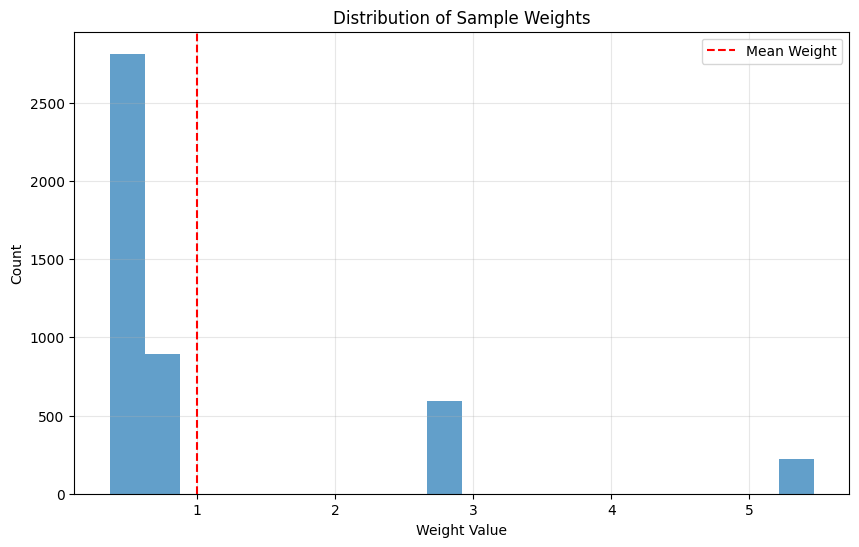

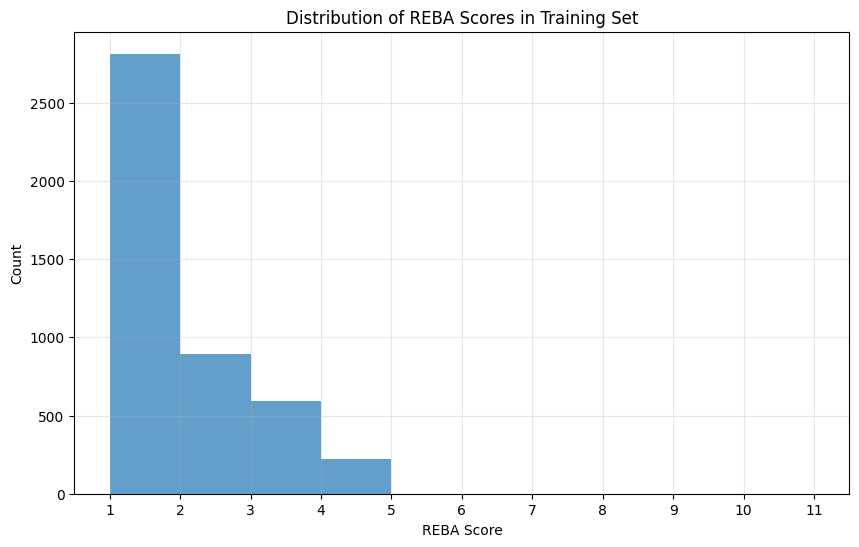

In [20]:
# 1. Temporal Validation Split (Last 20% per File)
def temporal_split(df, test_size=0.2):
    dfs = []
    for fn, group in df.groupby('File Name'):
        group = group.sort_values('Frame')
        split_idx = int(len(group) * (1 - test_size))
        train_part = group.iloc[:split_idx].copy()
        val_part = group.iloc[split_idx:].copy()
        train_part['split'] = 'train'
        val_part['split'] = 'val'
        dfs.append(pd.concat([train_part, val_part]))
    return pd.concat(dfs)

# Apply temporal split
df = temporal_split(df)
train_df = df[df['split'] == 'train'].copy()
val_df = df[df['split'] == 'val'].copy()

# 2. Clean data before scaling
# Replace infinities and NaNs with zeros in features
for feature_set in [train_df, val_df]:
    feature_set[model_features] = feature_set[model_features].replace([np.inf, -np.inf], np.nan)
    feature_set[model_features] = feature_set[model_features].fillna(0)

# 3. Fit scaler ONLY on training data
scaler = RobustScaler()
train_df[model_features] = scaler.fit_transform(train_df[model_features])
val_df[model_features] = scaler.transform(val_df[model_features])

# 4. Gap-Aware Sequence Preparation with Index Tracking
SEQUENCE_LENGTH = 60
STRIDE = 30
MAX_GAP = 30

def prepare_sequences(df, model_features, 
                     sequence_length=SEQUENCE_LENGTH,
                     stride=STRIDE,
                     max_gap=MAX_GAP):
    sequences, targets, groups, frame_indices = [], [], [], []
    
    for video_id, group in df.groupby('File Name'):
        group = group.sort_values('Frame').reset_index(drop=True)
        frames = group['Frame'].values
        data = group[model_features].values
        
        i = 0
        while i < len(group) - sequence_length + 1:
            seq_frames = frames[i:i+sequence_length]
            gaps = np.diff(seq_frames)
            
            if np.any(gaps > max_gap):
                bad_pos = np.where(gaps > max_gap)[0][0]
                i += bad_pos + 1
                continue
                
            sequences.append(data[i:i+sequence_length])
            targets.append(group.iloc[i+sequence_length-1]['REBA Grand Total'])
            groups.append(video_id)
            frame_indices.append((i, i+sequence_length))
            
            i += stride
    
    return (
        np.array(sequences), 
        np.array(targets), 
        groups,
        frame_indices
    )

# Generate sequences with indices
X_train, y_train, train_groups, train_frame_indices = prepare_sequences(train_df, model_features)
X_val, y_val, val_groups, val_frame_indices = prepare_sequences(val_df, model_features)

# 5. Improved Regression Weighting for better balanced learning
def calculate_regression_weights(y_train):
    """Enhanced regression weight function focusing on high REBA scores"""
    # Normalize targets
    y_norm = (y_train - y_train.min()) / (y_train.max() - y_train.min())
    
    # More aggressive base emphasis on higher scores
    weights = 1 + 3 * y_norm  # 1-4 range instead of 1-2
    
    # Strong boost for high-risk cases (REBA >= 3)
    high_risk_mask = y_train >= 3.0
    weights[high_risk_mask] *= 2.5  # 2.5x boost for REBA 3+
    
    # Extra boost for very high-risk cases (REBA >= 4) 
    very_high_risk_mask = y_train >= 4.0
    weights[very_high_risk_mask] *= 1.5  # Additional 1.5x boost
    
    # Normalize to maintain same overall impact
    return weights / np.mean(weights)

train_weights = calculate_regression_weights(y_train)

# 6. Corrected Leakage Checks
# Verify temporal separation
for fn in df['File Name'].unique():
    train_frames = train_df[train_df['File Name'] == fn]['Frame']
    val_frames = val_df[val_df['File Name'] == fn]['Frame']
    
    if not train_frames.empty and not val_frames.empty:
        assert val_frames.min() > train_frames.max(), \
            f"Leakage in {fn}: Val starts at {val_frames.min()}, train ends at {train_frames.max()}"

# Verify sequence integrity using tracked indices
for (start, end), group in zip(train_frame_indices, train_groups):
    group_data = train_df[train_df['File Name'] == group]
    if start < len(group_data) and end <= len(group_data):
        seq_frames = group_data.iloc[start:end]['Frame'].values
        
        assert len(seq_frames) == SEQUENCE_LENGTH, \
            f"Sequence length mismatch in {group} ({len(seq_frames)} vs {SEQUENCE_LENGTH})"
        
        gaps = np.diff(seq_frames)
        assert np.all(gaps <= MAX_GAP), \
            f"Large gap in {group} sequence: Max gap {gaps.max()} frames"

# 7. Check for any data issues in prepared sequences
def check_sequence_data(X, name):
    """Check sequence data for potential issues"""
    print(f"\n--- {name} Sequence Stats ---")
    print(f"Shape: {X.shape}")
    print(f"Contains NaN: {np.isnan(X).any()}")
    print(f"Contains inf: {np.isinf(X).any()}")
    
    if np.isnan(X).any() or np.isinf(X).any():
        print("Warning: Found NaN or inf values in sequences!")
        
        # Count NaN/inf by feature
        nan_counts = np.isnan(X).sum(axis=(0,1))
        inf_counts = np.isinf(X).sum(axis=(0,1))
        
        for i, feature in enumerate(model_features):
            if nan_counts[i] > 0 or inf_counts[i] > 0:
                print(f"  {feature}: {nan_counts[i]} NaNs, {inf_counts[i]} infs")
        
        # Replace remaining NaNs/infs with zeros
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        print("Fixed by replacing with zeros.")
    
    return X

# Apply data quality checks and fixes
X_train = check_sequence_data(X_train, "Training")
X_val = check_sequence_data(X_val, "Validation")

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Sample weights shape: {train_weights.shape}")

# 8. Visualize weight distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train_weights, bins=20, alpha=0.7)
plt.title('Distribution of Sample Weights')
plt.xlabel('Weight Value')
plt.ylabel('Count')
plt.axvline(x=1.0, color='r', linestyle='--', label='Mean Weight')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Also visualize target distribution
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=range(1, 12), alpha=0.7)
plt.title('Distribution of REBA Scores in Training Set')
plt.xlabel('REBA Score')
plt.ylabel('Count')
plt.xticks(range(1, 12))
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [26]:
def build_lstm_baseline_model(input_shape):
    """
    Build baseline LSTM model for REBA score prediction
    
    Architecture: 160-80-160 units (optimized configuration)
    
    Args:
        input_shape: (sequence_length, features) - typically (60, 30)
    
    Returns:
        Compiled Keras model
    """
    inputs = Input(shape=input_shape, name='sequence_input')
    
    # First LSTM layer with higher capacity
    x = LSTM(
        160,  # Larger architecture for complex pattern capture
        return_sequences=True,
        kernel_regularizer=l2(0.01),
        recurrent_dropout=0.15,
        name='lstm_layer_1'
    )(inputs)
    x = LayerNormalization(name='layer_norm_1')(x)
    
    # Second LSTM layer 
    x = LSTM(
        80,   
        return_sequences=False,
        kernel_regularizer=l2(0.005),
        name='lstm_layer_2'
    )(x)
    x = LayerNormalization(name='layer_norm_2')(x)
    
    # Dense layers for final prediction
    x = Dense(
        160,  
        activation='swish',
        kernel_regularizer=l2(0.001),
        name='dense_layer'
    )(x)
    x = Dropout(0.25, name='dropout_layer')(x)
    
    # Output layer for REBA score regression
    outputs = Dense(1, activation='softplus', name='reba_output')(x)
    
    model = Model(inputs, outputs, name='LSTM_Baseline')
    return model

def generate_lstm_architecture_summary(input_shape=(60, 30)):
    """
    Generate a clean model architecture summary for methodology section
    """
    model = build_lstm_baseline_model(input_shape)
    
    print("\n" + "=" * 60)
    print("LSTM BASELINE MODEL ARCHITECTURE")
    print("=" * 60)
    
    model.summary()
    
    print(f"\nArchitecture Configuration:")
    print(f"- LSTM Layer 1: 160 units (return_sequences=True)")
    print(f"- LSTM Layer 2: 80 units (return_sequences=False)")
    print(f"- Dense Layer: 160 units (swish activation)")
    print(f"- Output Layer: 1 unit (softplus activation)")
    print(f"- Regularization: L2 + Dropout (0.25) + LayerNorm")
    print(f"- Total Parameters: {model.count_params():,}")
    print("=" * 60)
    
    return model

In [27]:
def build_bilstm_baseline_model(input_shape):
    """
    Build baseline Bidirectional LSTM model for REBA score prediction
    
    Architecture: Bidirectional 160-80-160 units (enhanced temporal understanding)
    
    Args:
        input_shape: (sequence_length, features) - typically (60, 30)
    
    Returns:
        Compiled Keras model
    """
    inputs = Input(shape=input_shape, name='sequence_input')
    
    # First Bidirectional LSTM layer with higher capacity
    x = Bidirectional(
        LSTM(
            160,  # Enhanced architecture for complex pattern capture
            return_sequences=True,
            kernel_regularizer=l2(0.01),
            recurrent_dropout=0.15,
            name='lstm_layer_1'
        ),
        name='bidirectional_1'
    )(inputs)
    x = LayerNormalization(name='layer_norm_1')(x)
    
    # Second Bidirectional LSTM 
    x = Bidirectional(
        LSTM(
            80,   
            return_sequences=False,
            kernel_regularizer=l2(0.005),
            name='lstm_layer_2'
        ),
        name='bidirectional_2'
    )(x)
    x = LayerNormalization(name='layer_norm_2')(x)
    
    # Dense layers for final prediction
    x = Dense(
        160,  # Dense layer matching first LSTM dimension
        activation='swish',
        kernel_regularizer=l2(0.001),
        name='dense_layer'
    )(x)
    x = Dropout(0.25, name='dropout_layer')(x)
    
    # Output layer for REBA score regression
    outputs = Dense(1, activation='softplus', name='reba_output')(x)
    
    model = Model(inputs, outputs, name='BiLSTM_Baseline')
    return model

def generate_bilstm_architecture_summary(input_shape=(60, 30)):
    """
    Generate a clean model architecture summary for methodology section
    """
    model = build_bilstm_baseline_model(input_shape)
    
    print("\n" + "=" * 60)
    print("BIDIRECTIONAL LSTM BASELINE MODEL ARCHITECTURE")
    print("=" * 60)
    
    model.summary()
    
    print(f"\nArchitecture Configuration:")
    print(f"- BiLSTM Layer 1: 160×2 units (return_sequences=True)")
    print(f"- BiLSTM Layer 2: 80×2 units (return_sequences=False)")
    print(f"- Dense Layer: 160 units (swish activation)")
    print(f"- Output Layer: 1 unit (softplus activation)")
    print(f"- Regularization: L2 + Dropout (0.25) + LayerNorm")
    print(f"- Bidirectional processing: Enabled")
    print(f"- Total Parameters: {model.count_params():,}")
    print("=" * 60)
    
    return model

In [30]:
def setup_training_configuration():
    """
    Setup shared training configuration for both LSTM and BiLSTM baselines
    Based on optimal hyperparameters from ablation study
    """
    config = {
        'learning_rate': 0.0004,
        'weight_decay': 0.0005,
        'batch_size': 256,
        'epochs': 500,
        'patience': 50,
        'clipnorm': 0.8
    }
    return config

def create_learning_rate_schedule():
    """
    Learning rate schedule with warmup and cosine decay
    Optimized for REBA regression task
    """
    def lr_schedule(epoch):
        warmup_epochs = 20
        initial_lr = 1e-4
        peak_lr = 8e-4
        final_lr = 1e-6
        
        if epoch < warmup_epochs:
            # Warmup phase
            return initial_lr + (peak_lr - initial_lr) * (epoch / warmup_epochs)
        else:
            # Cosine decay phase
            decay_epochs = epoch - warmup_epochs
            total_decay_epochs = 200 - warmup_epochs
            cosine_decay = 0.5 * (1 + np.cos(np.pi * decay_epochs / total_decay_epochs))
            return final_lr + (peak_lr - final_lr) * cosine_decay
    
    return lr_schedule

def train_baseline_model(model, X_train, y_train, X_val, y_val, train_weights, model_features, model_name):
    """
    Train baseline model (LSTM or BiLSTM) with shared configuration
    
    Args:
        model: Built model (from build_lstm_baseline_model or build_bilstm_baseline_model)
        X_train: Training sequences (samples, 60, features)
        y_train: Training targets (REBA scores)
        X_val: Validation sequences
        y_val: Validation targets
        train_weights: Sample weights for imbalanced learning
        model_features: List of feature names
        model_name: "LSTM" or "BiLSTM"
    
    Returns:
        tuple: (trained_model, training_history)
    """
    
    # Setup training configuration
    config = setup_training_configuration()
    
    # Setup optimizer
    optimizer = AdamW(
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        global_clipnorm=config['clipnorm']
    )
    
    # Compile model
    model.compile(
        loss=MeanAbsoluteError(),  # L1 loss
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )
    
    # Print model summary
    print("=" * 60)
    print(f"{model_name} BASELINE MODEL")
    print("=" * 60)
    print(f"Input shape: {model.input_shape}")
    print(f"Total parameters: {model.count_params():,}")
    print(f"Training samples: {X_train.shape[0]:,}")
    print(f"Validation samples: {X_val.shape[0]:,}")
    print(f"Features used: {len(model_features)}")
    print("=" * 60)
    
    # Setup callbacks
    lr_scheduler = LearningRateScheduler(create_learning_rate_schedule())
    
    callbacks = [
        EarlyStopping(
            patience=config['patience'],
            monitor='val_mae',
            mode='min',
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_mae',
            factor=0.5,
            patience=30,
            min_lr=1e-5,
            verbose=1
        ),
        lr_scheduler
    ]
    
    # Train model
    print(f"\nStarting {model_name} training...")
    history = model.fit(
        X_train, y_train,
        sample_weight=train_weights,
        validation_data=(X_val, y_val),
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    
    # Final evaluation
    final_train_metrics = model.evaluate(X_train, y_train, verbose=0)
    final_val_metrics = model.evaluate(X_val, y_val, verbose=0)
    
    print("\n" + "=" * 60)
    print(f"FINAL {model_name} BASELINE RESULTS")
    print("=" * 60)
    print(f"Training MAE: {final_train_metrics[1]:.6f} REBA points")
    print(f"Training MSE: {final_train_metrics[2]:.6f}")
    print(f"Validation MAE: {final_val_metrics[1]:.6f} REBA points")
    print(f"Validation MSE: {final_val_metrics[2]:.6f}")
    print(f"Total epochs: {len(history.history['loss'])}")
    print("=" * 60)
    
    return model, history

def create_evaluation_plots(history, model, X_train, y_train, X_val, y_val, 
                          model_name="LSTM", save_dir='baseline'):
    """
    Create evaluation plots with scatter plots and error visualization
    Based on the regression analysis code style
    
    Args:
        history: Training history from model.fit()
        model: Trained model
        X_train, y_train: Training data
        X_val, y_val: Validation data
        model_name: Name for plots (e.g., "LSTM", "BiLSTM")
        save_dir: Directory to save plots
    """
    
    # Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Generate predictions
    train_pred = model.predict(X_train, verbose=0).flatten()
    val_pred = model.predict(X_val, verbose=0).flatten()
    
    # Calculate R² scores
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots (2x3 layout)
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle(f'{model_name} Baseline Model - Comprehensive Evaluation', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history.history['loss']) + 1)
    
    # 1. MAE Progress (Training vs Validation)
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(epochs, history.history['mae'], 'b-', label='Training MAE', linewidth=2)
    plt.plot(epochs, history.history['val_mae'], 'r-', label='Validation MAE', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('MAE (REBA Points)')
    plt.title('Mean Absolute Error Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add best MAE annotation
    best_val_mae = min(history.history['val_mae'])
    best_epoch = history.history['val_mae'].index(best_val_mae) + 1
    plt.annotate(f'Best: {best_val_mae:.4f}', 
                xy=(best_epoch, best_val_mae), 
                xytext=(best_epoch + 20, best_val_mae + 0.01),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=9)
    
    # 2. MSE Progress (Training vs Validation)
    ax2 = plt.subplot(2, 3, 2)
    plt.plot(epochs, history.history['mse'], 'b-', label='Training MSE', linewidth=2)
    plt.plot(epochs, history.history['val_mse'], 'r-', label='Validation MSE', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('MSE (REBA²)')
    plt.title('Mean Squared Error Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Training Set - Prediction vs Actual Scatter Plot
    ax3 = plt.subplot(2, 3, 3)
    plt.scatter(y_train, train_pred, alpha=0.6, s=20, label=f'Train (R²={train_r2:.3f})')
    plt.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('Actual REBA Score')
    plt.ylabel('Predicted REBA Score')
    plt.title('Training Set - Prediction vs Actual')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(0.8, 5.2)
    plt.ylim(0.8, 5.2)
    
    # 4. Validation Set - Prediction vs Actual Scatter Plot
    ax4 = plt.subplot(2, 3, 4)
    plt.scatter(y_val, val_pred, alpha=0.6, s=20, label=f'Validation (R²={val_r2:.3f})', color='orange')
    plt.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('Actual REBA Score')
    plt.ylabel('Predicted REBA Score')
    plt.title('Validation Set - Prediction vs Actual')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(0.8, 5.2)
    plt.ylim(0.8, 5.2)
    
    # 5. Training Set - Error Distribution
    ax5 = plt.subplot(2, 3, 5)
    train_errors = np.abs(y_train - train_pred)
    plt.hist(train_errors, bins=30, alpha=0.7, density=True, label='Train')
    train_mae = np.mean(train_errors)
    plt.axvline(train_mae, color='red', linestyle='--', linewidth=2, label=f'MAE: {train_mae:.4f}')
    plt.xlabel('Absolute Error')
    plt.ylabel('Density')
    plt.title('Training Set - Error Distribution')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 6. Validation Set - Error Distribution  
    ax6 = plt.subplot(2, 3, 6)
    val_errors = np.abs(y_val - val_pred)
    plt.hist(val_errors, bins=30, alpha=0.7, density=True, label='Validation', color='orange')
    val_mae = np.mean(val_errors)
    plt.axvline(val_mae, color='red', linestyle='--', linewidth=2, label=f'MAE: {val_mae:.4f}')
    plt.xlabel('Absolute Error')
    plt.ylabel('Density')
    plt.title('Validation Set - Error Distribution')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    
    # Save plot
    save_path = os.path.join(save_dir, f'{model_name.lower()}_comprehensive_evaluation.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"{model_name} comprehensive evaluation saved to: {save_path}")
    
    plt.show()
    
    # Print final metrics
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]
    final_train_mse = history.history['mse'][-1]
    final_val_mse = history.history['val_mse'][-1]
    
    print(f"\n{model_name} COMPREHENSIVE EVALUATION METRICS:")
    print("-" * 50)
    print(f"MAE  - Train: {final_train_mae:.6f}, Validation: {final_val_mae:.6f}")
    print(f"MSE  - Train: {final_train_mse:.6f}, Validation: {final_val_mse:.6f}")
    print(f"R²   - Train: {train_r2:.6f}, Validation: {val_r2:.6f}")
    print(f"Best Validation MAE: {best_val_mae:.6f} (Epoch {best_epoch})")

def save_baseline_model(model, model_name, save_dir='baseline'):
    """
    Save the baseline model and generate summary
    
    Args:
        model: Trained baseline model
        model_name: "LSTM" or "BiLSTM"
        save_dir: Directory to save model
    """
    
    # Create baseline directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save model
    model_path = os.path.join(save_dir, f'{model_name.lower()}_baseline.h5')
    model.save(model_path)
    print(f"{model_name} Model saved to: {model_path}")
    
    # Save model summary to text file
    summary_path = os.path.join(save_dir, f'{model_name.lower()}_model_summary.txt')
    with open(summary_path, 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    print(f"{model_name} Model summary saved to: {summary_path}")

# Complete training functions using architecture functions from cells above

def train_lstm_baseline_complete(X_train, y_train, X_val, y_val, train_weights, model_features):
    """
    Complete LSTM baseline training with evaluation
    """
    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_baseline_model(input_shape)
    
    # Train model
    model, history = train_baseline_model(
        model, X_train, y_train, X_val, y_val, train_weights, model_features, "LSTM"
    )
    
    # Create evaluation plots
    create_evaluation_plots(history, model, X_train, y_train, X_val, y_val, "LSTM")
    
    # Save model
    save_baseline_model(model, "LSTM")
    
    return model, history

def train_bilstm_baseline_complete(X_train, y_train, X_val, y_val, train_weights, model_features):
    """
    Complete BiLSTM baseline training with evaluation
    """
    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_bilstm_baseline_model(input_shape)
    
    # Train model
    model, history = train_baseline_model(
        model, X_train, y_train, X_val, y_val, train_weights, model_features, "BiLSTM"
    )
    
    # Create evaluation plots
    create_evaluation_plots(history, model, X_train, y_train, X_val, y_val, "BiLSTM")
    
    # Save model
    save_baseline_model(model, "BiLSTM")
    
    return model, history

LSTM BASELINE MODEL
Input shape: (None, 60, 30)
Total parameters: 212,961
Training samples: 4,529
Validation samples: 1,121
Features used: 30

Starting LSTM training...
Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step - loss: 3.5618 - mae: 0.8224 - mse: 1.4121 - val_loss: 2.1831 - val_mae: 0.4519 - val_mse: 0.3637 - learning_rate: 1.0000e-04
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - loss: 2.4087 - mae: 0.6236 - mse: 0.6785 - val_loss: 2.0845 - val_mae: 0.3853 - val_mse: 0.3202 - learning_rate: 1.3500e-04
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 2.2324 - mae: 0.4801 - mse: 0.4487 - val_loss: 2.0182 - val_mae: 0.3651 - val_mse: 0.3265 - learning_rate: 1.7000e-04
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - loss: 2.1207 - mae: 0.4395 - mse: 0.3829 - val_loss: 1.9468 - val_mae: 0.3528 - val_mse: 0.3103 - learning_rate: 2.0500e-04
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - loss: 2.0182 - mae: 0.4033 - mse: 0.3416 - val_loss: 1.8461

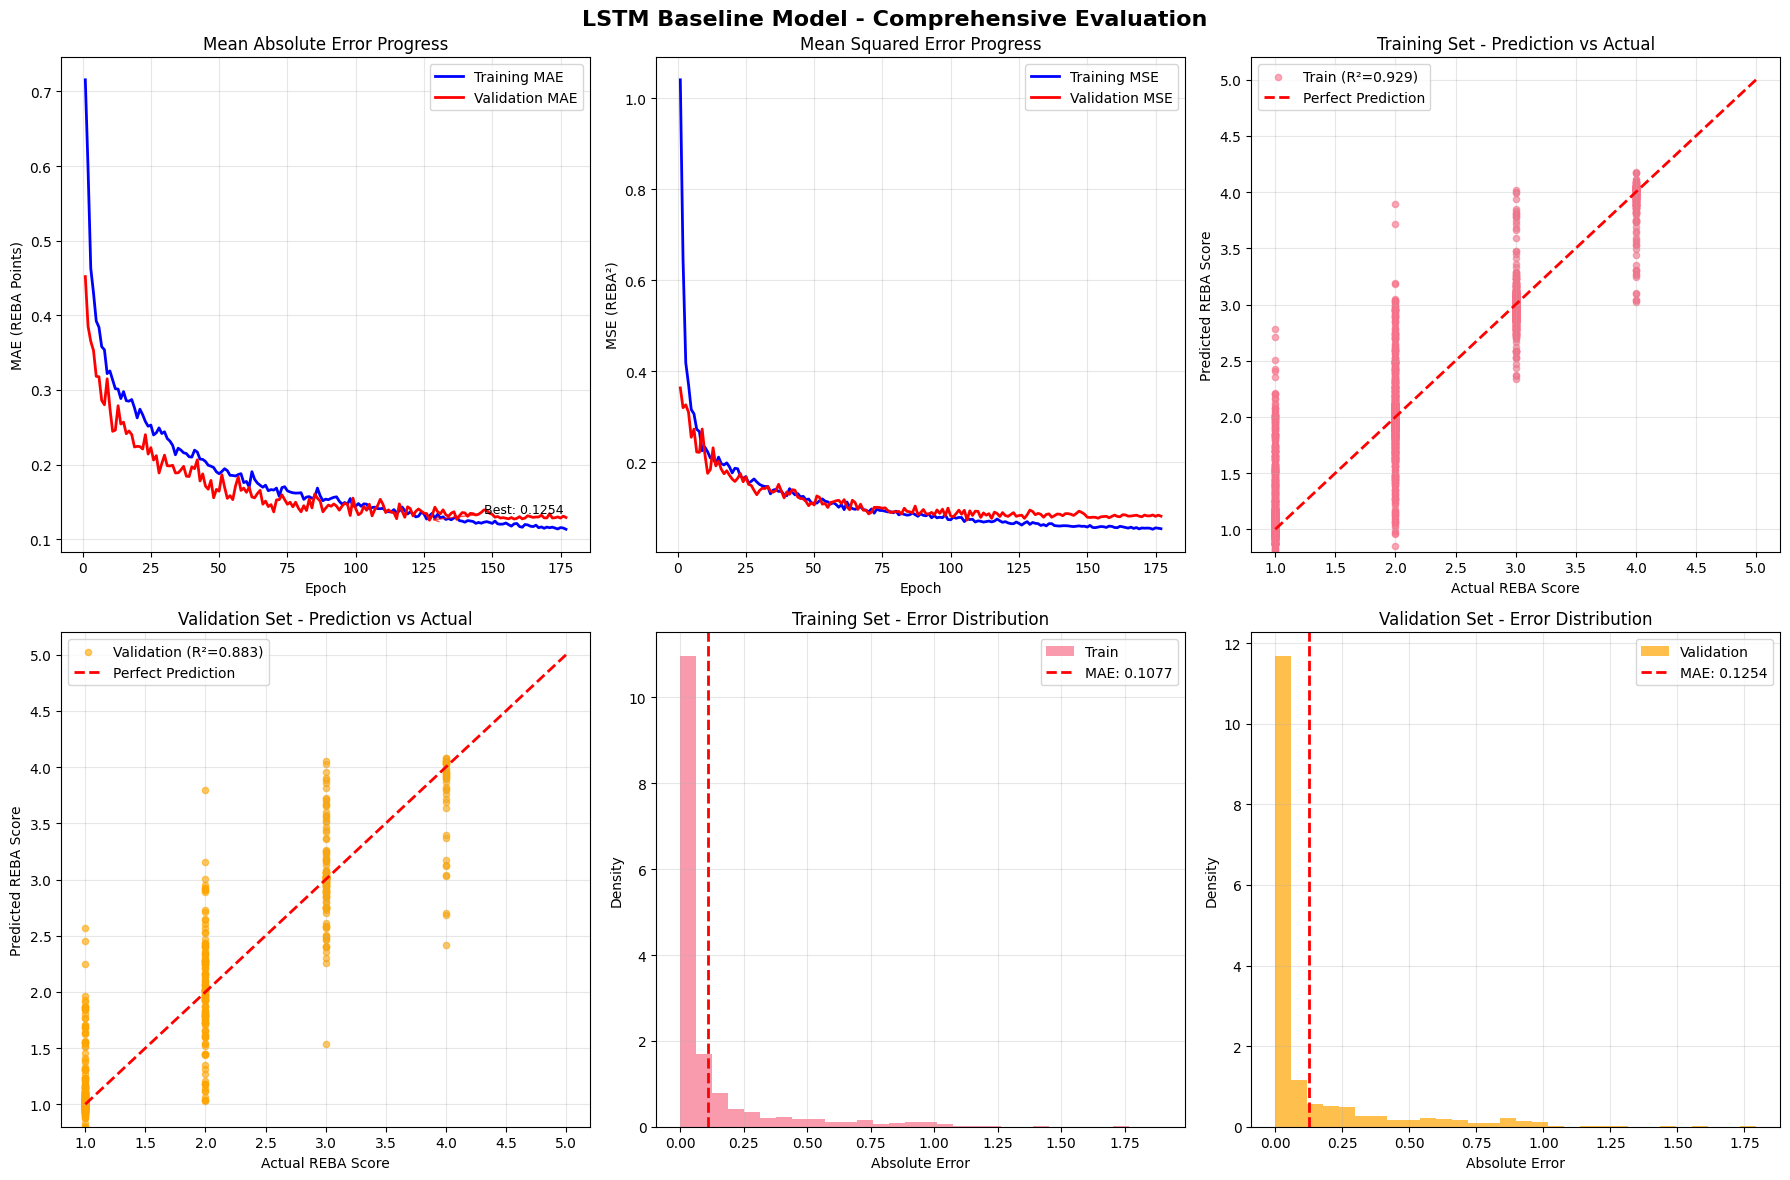


LSTM COMPREHENSIVE EVALUATION METRICS:
--------------------------------------------------
MAE  - Train: 0.113352, Validation: 0.129154
MSE  - Train: 0.054458, Validation: 0.082040
R²   - Train: 0.928874, Validation: 0.883494
Best Validation MAE: 0.125438 (Epoch 127)
LSTM Model saved to: baseline/lstm_baseline.h5


LSTM Model summary saved to: baseline/lstm_model_summary.txt


In [33]:
lstm_model, lstm_history = train_lstm_baseline_complete(
    X_train, y_train, X_val, y_val, train_weights, model_features
)


BiLSTM BASELINE MODEL
Input shape: (None, 60, 30)
Total parameters: 528,001
Training samples: 4,529
Validation samples: 1,121
Features used: 30

Starting BiLSTM training...
Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 658ms/step - loss: 4.1974 - mae: 0.3921 - mse: 0.2917 - val_loss: 3.9212 - val_mae: 0.3029 - val_mse: 0.2030 - learning_rate: 2.7500e-04
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 737ms/step - loss: 3.9629 - mae: 0.3812 - mse: 0.2769 - val_loss: 3.6999 - val_mae: 0.3116 - val_mse: 0.2416 - learning_rate: 3.1000e-04
Epoch 8/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 728ms/step - loss: 3.7157 - mae: 0.3795 - mse: 0.2805 - val_loss: 3.4191 - val_mae: 0.2752 - val_mse: 0.1749 - learning_rate: 3.4500e-04
Epoch 9/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 715ms/step - loss: 3.4325 - mae: 0.3430 - mse: 0.2277 - val_loss: 3.1701 - val_mae: 0.2828 - val_mse: 0.1838 - learning_rate: 3.8000e-04
Epoch 10/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 567ms/step - loss: 3.1720 - mae: 0.3244 - mse: 0.2049 - val_los

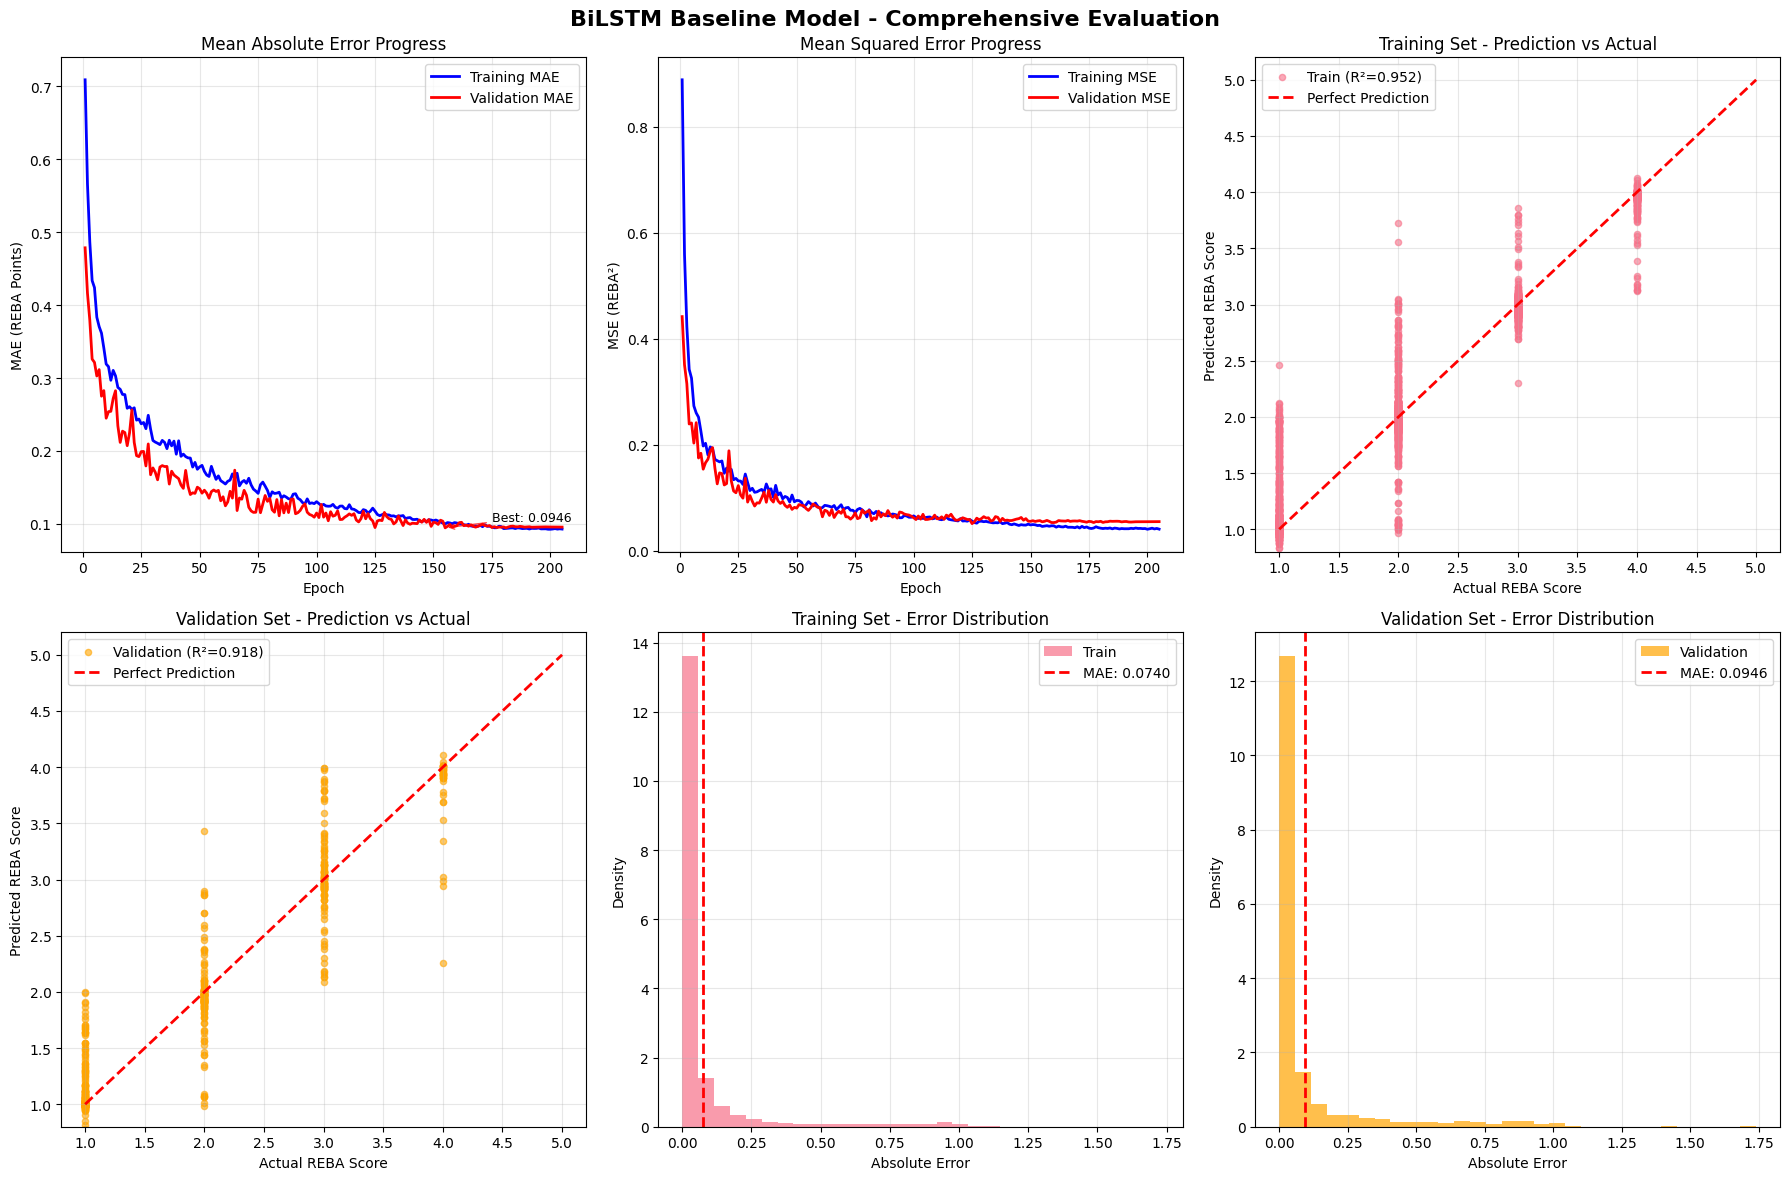


BiLSTM COMPREHENSIVE EVALUATION METRICS:
--------------------------------------------------
MAE  - Train: 0.092943, Validation: 0.095632
MSE  - Train: 0.040611, Validation: 0.054769
R²   - Train: 0.951854, Validation: 0.918041
Best Validation MAE: 0.094605 (Epoch 155)
BiLSTM Model saved to: baseline/bilstm_baseline.h5


BiLSTM Model summary saved to: baseline/bilstm_model_summary.txt


In [34]:
bilstm_model, bilstm_history = train_bilstm_baseline_complete(
    X_train, y_train, X_val, y_val, train_weights, model_features
)
